# Predicting the Stock Market

## Introduction


In this project, we'll be working with data from the S&P500 Index. The S&P500 is a stock market index. Before we get into what an index is, we'll need to get into the basics of the stock market.

Some companies are publicly traded, which means that anyone can buy and sell their shares on the open market. A share entitles the owner to some control over the direction of the company, and to some percentage (or share) of the earnings of the company. When you buy or sell shares, it's common to say that you're trading a stock.

The price of a share is based mainly on supply and demand for a given stock. For example, Apple stock has a price of 120 dollars per share as of December 2015 -- http://www.nasdaq.com/symbol/aapl. A stock that is in less demand, like Ford Motor Company, has a lower price -- http://finance.yahoo.com/q?s=F. Stock price is also influenced by other factors, including the number of shares a company has issued.

Stocks are traded daily, and the price can rise or fall from the beginning of a trading day to the end based on demand. Stocks that are in more in demand, such as Apple, are traded more often than stocks of smaller companies.

Indexes aggregate the prices of multiple stocks together, and allow you to see how the market as a whole is performing. For example, the Dow Jones Industrial Average aggregates the stock prices of 30 large American companies together. The S&P500 Index aggregates the stock prices of 500 large companies. When an index fund goes up or down, you can say that the underlying market or sector it represents is also going up or down. For example, if the Dow Jones Industrial Average price goes down one day, you can say that American stocks overall went down (ie, most American stocks went down in price).

You'll be using historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index will go up or down will help us forecast how the stock market as a whole will perform. Since stocks tend to correlate with how well the economy as a whole is performing, it can also help us make economic forecasts.

There are also thousands of traders who make money by buying and selling Exchange Traded Funds. ETFs allow you to buy and sell indexes like stocks. This means that you could "buy" the S&P500 Index ETF when the price is low, and sell when it's high to make a profit. Creating a predictive model could allow traders to make money on the stock market.

Note: You shouldn't make trades with any models developed in this mission. Trading stocks has risks, and nothing in this mission constitutes stock trading advice.

In this mission, you'll be working with a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from 1950 to 2015. The dataset is stored in sphist.csv.

The columns of the dataset are:

Date -- The date of the record

Open -- The opening price of the day (when trading starts).

High -- The highest trade price during the day.

Low -- The lowest trade price during the day.

Close -- The closing price for the day (when trading is finished).

Volume -- The number of shares traded.

Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions.

You'll be using this dataset to develop a predictive model. You'll train the model with data from 1950-2012, and try to make predictions from 2013-2015.

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [16]:
#Read the data and change the date column to datetime objects
df=pd.read_csv("~/Documents/Data Science/Projects/Data/sphist.csv")
print(df.head())
df['Date']=pd.to_datetime(df['Date'])

#Sort by date from oldest to newest
df=df.sort_values('Date',ascending=True)

         Date         Open         High          Low        Close  \
0  2015-12-07  2090.419922  2090.419922  2066.780029  2077.070068   
1  2015-12-04  2051.239990  2093.840088  2051.239990  2091.689941   
2  2015-12-03  2080.709961  2085.000000  2042.349976  2049.620117   
3  2015-12-02  2101.709961  2104.270020  2077.110107  2079.510010   
4  2015-12-01  2082.929932  2103.370117  2082.929932  2102.629883   

         Volume    Adj Close  
0  4.043820e+09  2077.070068  
1  4.214910e+09  2091.689941  
2  4.306490e+09  2049.620117  
3  3.950640e+09  2079.510010  
4  3.712120e+09  2102.629883  


Datasets taken from the stock market need to be handled differently than datasets from other sectors when it comes time to make predictions. In a normal machine learning exercise, we treat each row as independent. Stock market data is sequential, and each observation comes a day after the previous observation. Thus, the observations are not all independent, and you can't treat them as such.

This means you have to be extra careful to not inject "future" knowledge into past rows when you do training and prediction. Injecting future knowledge will make our model look good when you're training and testing it, but will make it fail in the real world. This is how many algorithmic traders lose money.

The time series nature of the data means that can generate indicators to make our model more accurate. For instance, you can create a new column that contains the average price of the last 10 trades for each row. This will incorporate information from multiple prior rows into one, and will make predictions much more accurate.

When you do this, you have to be careful not to use the current row in the values you average. You want to teach the model how to predict the current price from historical prices. If you include the current price in the prices you average, it will be equivalent to handing the answers to the model upfront, and will make it impossible to use in the "real world", where you don't know the price upfront.

Here are some indicators that are interesting to generate for each row:

The average price from the past 5 days.<br>
The average price for the past 30 days.<br>
The average price for the past 365 days.<br>
The ratio between the average price for the past 5 days, and the average price for the past 365 days.<br>
The standard deviation of the price over the past 5 days.<br>
The standard deviation of the price over the past 365 days.<br>

The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.
"Days" means "trading days" -- so if you're computing the average of the past 5 days, it should be the 5 most recent dates before the current one. Assume that "price" means the Close column. Always be careful not to include the current price in these indicators! You're predicting the next day price, so our indicators are designed to predict the current price from the previous prices.

Some of these indicators require a year of historical data to compute. Our first day of data falls on 1950-01-03, so the first day you can start computing indicators on is 1951-01-03.

To compute indicators, you'll need to loop through each day from 1951-01-03 to 2015-12-07 (the last day you have prices for). For instance, if we were computing the average price from the past 5 days, we'd start at 1951-01-03, get the prices for each day from 1950-12-26 to 1951-01-02, and find the average. The reason why we start on the 26th, and take more than 5 calendar days into account is because the stock market is shutdown on certain holidays. Since we're looking at the past 5 trading days, we need to look at more than 5 calendar days to find them. Here's a diagram showing how we average 5 days to get the average closing price for 1951-01-03:
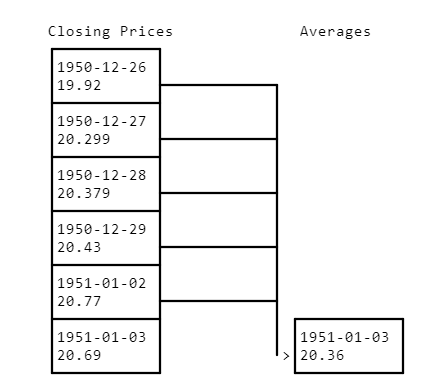


You'd then move to 1951-01-04, and find the average price from 1950-12-30 to 1951-01-03. Here's a diagram showing how we might compute the average here:
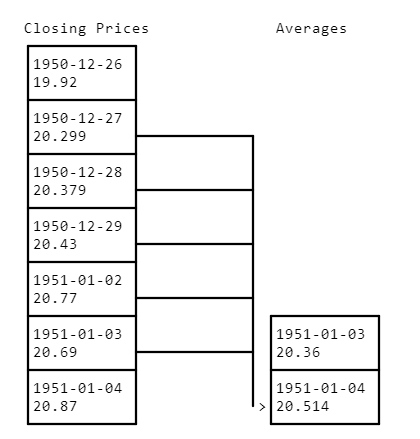

We'd keep repeating this process to compute all of the averages. Note how when we compute the average of the past 5 days for 1951-01-04, we don't include 1951-01-04 in that average. It's critical not to do this, or our model won't work in the "real world".

Here's a table of how the first 10 dates would look if we computed the 5 day average closing price. Close is the closing price for that day, and day_5 is the average of the past 5 trading closing prices at each row:
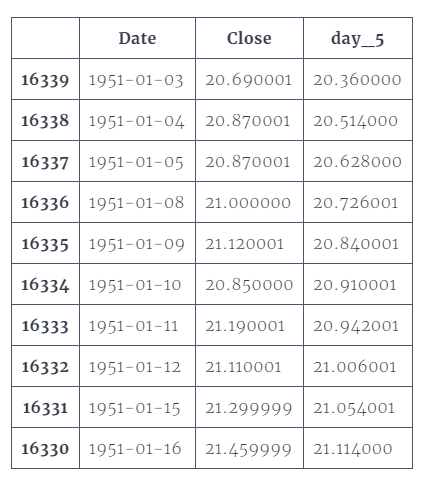

Instructions:

Pick 3 indicators to compute, and generate a different column for each one.

There are a few different ways to do this:

You can use a for loop along with the iterrows method to loop over the rows in the DataFrame and compute the indicators. This is the recommended way, as it's a bit simpler to understand what's happening. Since you'll be looping over all of the rows, for any date that comes before there is enough historical data to compute an indicator, just fill in 0.<br>
Pandas has some time series tools that can help, including the rolling function, which will do most of the hard computation for you. Set the window equal to the number of trading days in the past you want to use to compute the indicators. This will add in NaN values for any row where there aren't enough historical trading days to do the computation. Note: There is a giant caveat here, which is that the rolling mean will use the current day's price. You'll need to reindex the resulting series to shift all the values "forward" one day. For example, the rolling mean calculated for 1950-01-03 will need to be assigned to 1950-01-04, and so on. You can use the shift method on Dataframes to do this.

In [86]:
#Add features that could be helpful for machine learning
df['5 Days Open'] = df['Open'].rolling(window=5).mean()
df['5 Days High'] = df['High'].rolling(window=5).mean()
df['5 Days Low'] = df['Low'].rolling(window=5).mean()
df['5 Days Volume'] = df['Volume'].rolling(window=5).mean()

#Create a year column
df['Year'] = df['Date'].apply(lambda x: x.year)

#Adding Day of week column and set it to categorical
df['DOW'] = df['Date'].apply(lambda x: x.weekday())
df_dow=pd.get_dummies(df['DOW'])
df=pd.concat([df,df_dow],axis=1)
#Display all columns names + type
df.dtypes
df.drop(['DOW'],axis=1)

#Shift columns by one (day n will take value of 5 previous days, needs mean of day n-1)
df['5 Days Open'] = df['5 Days Open'].shift(1)
df['5 Days High']=df['5 Days High'].shift(1)
df['5 Days Low']=df['5 Days Low'].shift(1)
df['5 Days Volume']=df['5 Days Volume'].shift(1)


Since you're computing indicators that use historical data, there are some rows where there isn't enough historical data to generate them. Some of the indicators use 365 days of historical data, and the dataset starts on 1950-01-03. Thus, any rows that fall before 1951-01-03 don't have enough historical data to compute all the indicators. You'll need to remove these rows before you split the data.

If you have a Dataframe df, you can select any rows with the Date column greater than 1951-01-02 using df[df["Date"] > datetime(year=1951, month=1, day=2)].

In [88]:
df=df[df['Date']>=datetime(year=1951,month=1,day=3)]
df.dropna(axis=0)
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,5 Days Open,5 Days High,5 Days Low,...,0,1,2,3,4,0,1,2,3,4
16339,1951-01-03,20.690001,20.690001,20.690001,20.690001,3370000.0,20.690001,20.360000,20.360000,20.360000,...,0,0,1,0,0,0,0,1,0,0
16338,1951-01-04,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.514000,20.514000,20.514000,...,0,0,0,1,0,0,0,0,1,0
16337,1951-01-05,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.628000,20.628000,20.628000,...,0,0,0,0,1,0,0,0,0,1
16336,1951-01-08,21.000000,21.000000,21.000000,21.000000,2780000.0,21.000000,20.726001,20.726001,20.726001,...,1,0,0,0,0,1,0,0,0,0
16335,1951-01-09,21.120001,21.120001,21.120001,21.120001,3800000.0,21.120001,20.840001,20.840001,20.840001,...,0,1,0,0,0,0,1,0,0,0


Generate two new dataframes to use in making our algorithm. train should contain any rows in the data with a date less than 2013-01-01. test should contain any rows with a date greater than or equal to 2013-01-01.

We will verify the model MAE as an error metric, because it will show you how "close" you were to the price in intuitive terms. Mean Squared Error, or MSE, is an alternative that is more commonly used, but makes it harder to intuitively tell how far off you are from the true price because it squares the error.

In [95]:
#Create train and test dataset
date_half=datetime(year=2013,month=1,day=1)
train = df[df['Date'] < date_half]
test = df[df['Date'] >= date_half]

#Leave out all of the original columns (Close, High, Low, Open, Volume, Adj Close, Date) when training your model.
#These all contain knowledge of the future that you don't want to feed the model. Use the Close column as the target.
features = ['5 Days Open', '5 Days Volume', '5 Days High', '5 Days Low', 'Year', 0, 1, 2, 3, 4]

#Linear Regression
lr = LinearRegression()

#Fit model
lr.fit(train[features], train['Close'])

#Prediction
predictions = lr.predict(test[features])

#Verify the model by using MAE. MAE is the average absolute difference between X and Y
mae = mean_absolute_error(test['Close'] ,predictions)

#Return last row
print(df.tail(1))
print(mae)

        Date         Open         High          Low        Close  \
0 2015-12-07  2090.419922  2090.419922  2066.780029  2077.070068   

         Volume    Adj Close  5 Days Open  5 Days High   5 Days Low ...  0  1  \
0  4.043820e+09  2077.070068  2081.507959  2096.058057  2066.807983 ...  1  0   

   2  3  4  0  1  2  3  4  
0  0  0  0  1  0  0  0  0  

[1 rows x 128 columns]
14.600316723381631
